### Import and setup functions

In [1]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'main.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

import pandas as pd
import numpy as np
from dateutil.parser import parse
from datetime import datetime
import matplotlib.pyplot as plt

import main.apps.dataprovider as app
from main.apps.marketdata.models.fx.rate import FxSpotRange
from main.apps.dataprovider.models.profile import Profile
from main.apps.currency.models.fxpair import FxPair
from main.apps.dataprovider.models import Value

### Init Functions

In [2]:

def get_profile_mappings(profile):
    output = {}
    mappings = profile.mapping_set.all()
    for map in mappings:
        column_name = map.column_name
        values = map.value_set.all()
        value_map = {}
        for value in values:
            if value in value_map:
                continue
            if (value.mapping_type == Value.MappingType.FX_PAIR):
                value_map[value.from_value] = value.to_fxpair_id
            if (value.mapping_type == Value.MappingType.CURRENCY):
                value_map[value.from_value] = value.to_currency_id
            if (value.mapping_type == Value.MappingType.STRING):
                value_map[value.from_value] = value.to_value
        if column_name in output:
            output[column_name].append(value_map)
        else:
            output[column_name] = [value_map]
    return output

def replace_data(df, mappings):
    for column_name, column_maps in mappings.items():
        for map in column_maps:
            if not column_name:
                df.replace(map)
            else:
                df = df.replace({column_name: map})
    return df

def reformat_date(date, format='%m-%d-%y'):
    temp = date.str.split(r"/|-", n=-1, expand=True)
    for i in temp.columns:
        temp[i] = temp[i].str.slice(start=-2).str.zfill(2)
    return pd.to_datetime(temp.agg('-'.join, axis=1), format=format)
def normalize_values(df):
    df['Open'] = df[['Open Ask', 'Open Bid']].mean(axis=1)
    df['Low'] = df[['Low Ask', 'Low Bid']].mean(axis=1)
    df['High'] = df[['Ask High', 'Bid High']].mean(axis=1)

    # ===================remove holiday=================================
    numNaN = df[['Close', 'Open', 'Low', 'High']].isna().sum(axis=1)
    df.drop(df[numNaN > 2].index, inplace=True)

    # ====================fix the high and low===========================
    highLowSwitch = (df['High'] - df['Low']) < 0
    newLowp = df['Low'].where(~highLowSwitch, df['High']).copy()
    newHighp = df['High'].where(~highLowSwitch, df['Low']).copy()

    df['Low'] = newLowp
    df['High'] = newHighp

    zeroDist = (df['High'] - df['Low']) == 0
    df['Low'] = df['Low'].where(~zeroDist, (1 - 0.0025) * df['Low'])
    df['High'] = df['High'].where(~zeroDist, (1 + 0.0025) * df['High'])

    # ====================fix the close and open===========================
    for p in ['Open', 'Close']:
        higherThanHigh = (df['High'] - df[f'{p}']) < 0
        lowerThanLow = (df[f'{p}'] - df['Low']) < 0

        df[f'{p}'] = df[f'{p}'].where(~higherThanHigh, df['High'])
        df[f'{p}'] = df[f'{p}'].where(~lowerThanLow, df['Low'])
def interpolate_values(df, pair):
    df.loc[df['Currency'] == pair.id] = df.loc[df['Currency'] == pair.id].interpolate(
        method='linear',
        limit_direction='both',
        axis=0
    )

### Init Constants

In [3]:
APP_PATH = os.path.dirname(app.__file__)
STORAGE_PATH = APP_PATH + '/storage'
CSV_PATH = STORAGE_PATH + '/csv'
CSV_FILEPATH = CSV_PATH + '/fx_rate/' + 'ExchangeRates20210218.csv'
print(CSV_FILEPATH)

/home/jaychow/hedgedesk/hd_dash/main/apps/dataprovider/storage/csv/fx_rate/ExchangeRates20210218.csv


### Init Profile and get Mappings

In [4]:
profile = Profile.objects.get(pk=3)
mappings = get_profile_mappings(profile)

### Init CSV

In [5]:
df = pd.read_csv(CSV_FILEPATH)

/home/jaychow/miniconda3/envs/hd_dash/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (2,3,5,6,8,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Replace Currency with Mappings

In [6]:
df = replace_data(df=df, mappings=mappings)

### Clean Data

In [7]:
df.sort_values(by=['Currency', 'Date'])
df['Date'] = reformat_date(df['Date'].astype(str))
df.iloc[:, 2:] = df.iloc[:, 2:].replace(',', '', regex=True).astype('float64')
df.set_index('Date', inplace=True)
normalize_values(df)
for pair in FxPair.objects.all():
    interpolate_values(df, pair)

### Plot graph

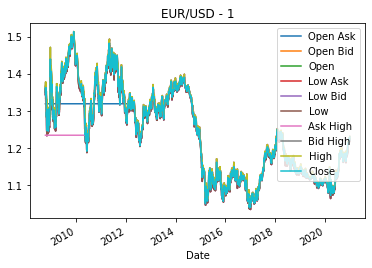

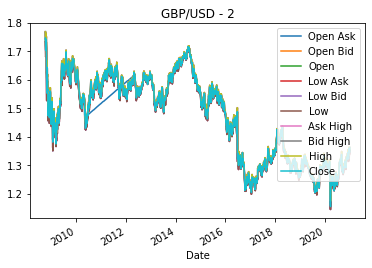

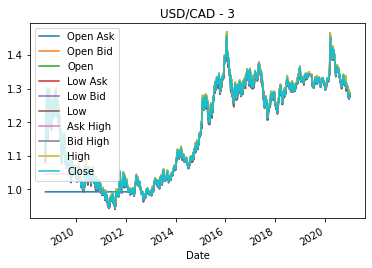

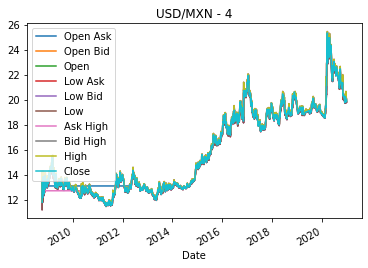

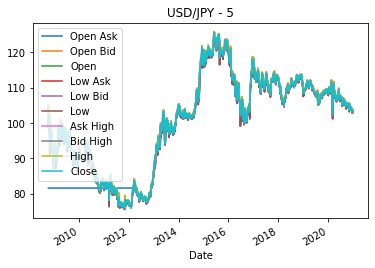

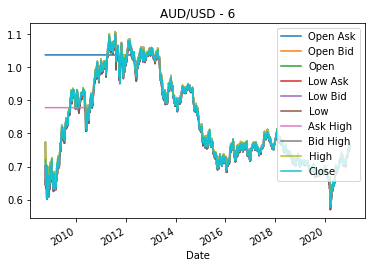

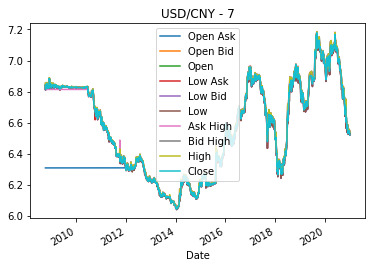

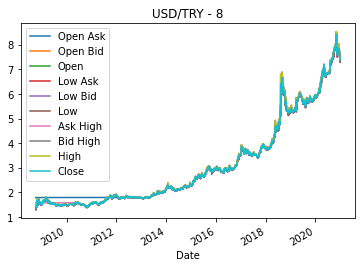

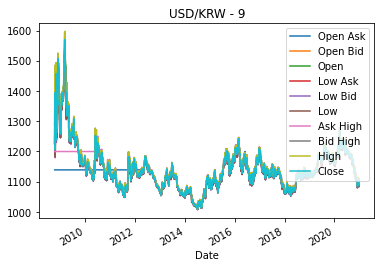

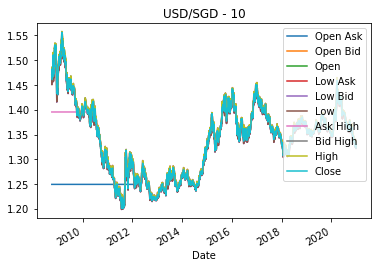

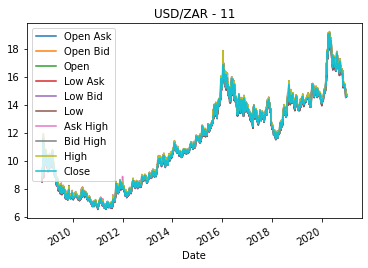

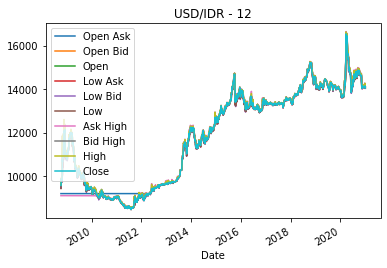

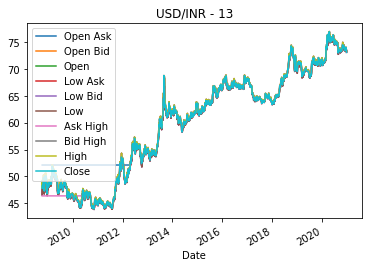

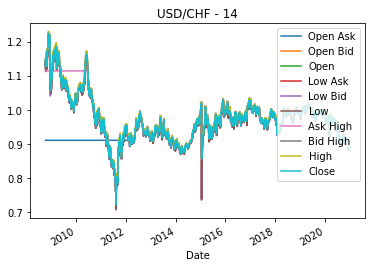

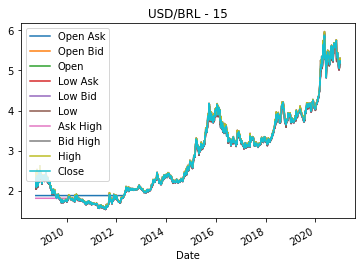

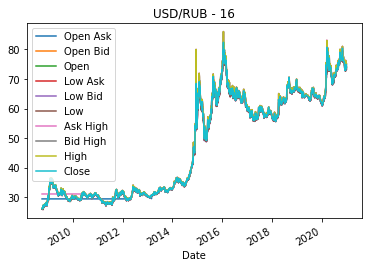

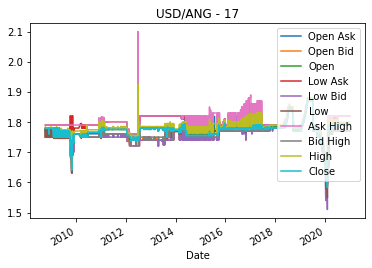

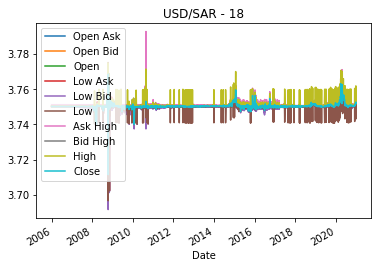

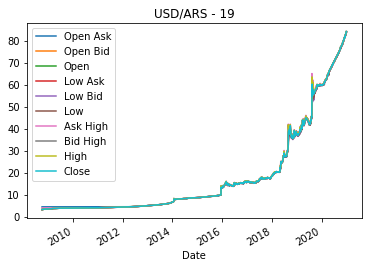

In [8]:
for pair in FxPair.objects.all():
    title = pair.__str__() + ' - ' + pair.id.__str__()
    df.loc[(df['Currency'] == pair.id), ['Open Ask', 'Open Bid', 'Open', 'Low Ask', 'Low Bid', 'Low', 'Ask High', 'Bid High', 'High', 'Close']].plot(title=title)
plt.show()
